In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import sunau
from scipy import signal
from scipy.io import wavfile
import pandas as pd
import pywt
import librosa
#import python_speech_features
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import pywt # Python wavelet transform implementation
from sklearn.base import BaseEstimator, TransformerMixin # Interfaces and base classes for pipeline components
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.fft import fft, ifft
import pickle
import more_itertools
import SignalTransformers
from kymatio.sklearn import Scattering1D
import SignalTransformers
from sklearn.metrics import f1_score

In [2]:
def loadWaveToArray(audioPath):
    sample_rate, samples = wavfile.read(audioPath)
    return samples

In [3]:
def loadAudioAndTranscript(basePath, timeStamp):
    audioPath = basePath + "audio" + timeStamp + ".wav"
    transcriptPath = basePath + "transcript" + timeStamp + ".txt"
    transcript_df = pd.read_csv(transcriptPath, names = ["key_code", "press_release", "time_stamp"])
    transcript_df["rel_time_stamp"] = transcript_df["time_stamp"] - int(timeStamp)
    sample_rate, samples = wavfile.read(audioPath)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    spectrogram = np.log(spectrogram)
    transposed_spec = spectrogram.transpose()
    freq_list = list(frequencies)
    #freq_list = [str(f) for f in freq_list]
    #freq_list = [f + " Hz" for f in freq_list]
    audio_df = pd.DataFrame(transposed_spec, index = times, columns = freq_list )
    audio_df.index = times
    audio_df
    return transcript_df, audio_df, samples, sample_rate

In [4]:
def constructSpectrogramFigure(audio_df, transcript_df):
    fig, ax = plt.subplots(figsize=(16, 4))
    im = plt.pcolormesh(audio_df.index, audio_df.columns, audio_df.transpose(), shading='auto')
    nkeys = len(transcript_df)
    dy = 8000 / nkeys
    y_pos = 8000 + dy
    for index, row in transcript_df.iterrows():
        plt.text((row["rel_time_stamp"] - 200) / 1000, y_pos - index * dy, row["key_code"])
    i = 0
    while i < len(audio_df)/16000:
        plt.axvline(i)
        i += .1

In [5]:
import glob
BASE_DIR = "C:\\Users\\kbk17\\Espionage-Data\\"
paths = glob.glob(BASE_DIR + "*.wav")
paths

['C:\\Users\\kbk17\\Espionage-Data\\audio1657405825762.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657405846489.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657405863666.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657405880674.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657405897594.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657405914498.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657405931394.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657405948290.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993281866.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993301012.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993324432.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993344379.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993367459.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993394222.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993419855.wav',
 'C:\\Users\\kbk17\\Espionage-Data\\audio1657993438879.wav',
 'C:\\Users\\kbk17\\Espi

In [6]:
audio_arrays = [loadWaveToArray(path) for path in paths]
audio_arrays

[array([174, 243, 238, ..., 126, 127, 126], dtype=uint8),
 array([174, 243, 238, ..., 127, 127, 127], dtype=uint8),
 array([174, 243, 238, ..., 130, 130, 130], dtype=uint8),
 array([174, 243, 238, ..., 127, 127, 127], dtype=uint8),
 array([174, 243, 238, ..., 126, 127, 126], dtype=uint8),
 array([174, 243, 238, ..., 128, 128, 127], dtype=uint8),
 array([174, 243, 238, ..., 130, 130, 130], dtype=uint8),
 array([174, 243, 238, ..., 127, 127, 127], dtype=uint8),
 array([174, 243, 238, ..., 126, 126, 126], dtype=uint8),
 array([174, 243, 238, ..., 125, 126, 125], dtype=uint8),
 array([174, 243, 238, ..., 126, 126, 126], dtype=uint8),
 array([174, 243, 238, ..., 127, 126, 126], dtype=uint8),
 array([174, 243, 238, ..., 133, 133, 133], dtype=uint8),
 array([174, 243, 238, ..., 125, 125, 125], dtype=uint8),
 array([174, 243, 238, ..., 128, 128, 128], dtype=uint8),
 array([174, 243, 238, ..., 129, 129, 129], dtype=uint8),
 array([174, 243, 238, ..., 126, 126, 126], dtype=uint8),
 array([174, 2

In [7]:
LONGEST = 239000 #longest audio array

In [8]:
from SignalTransformers import Normalizer
from SignalTransformers import NormFFT
model_path = "C:/Users/kbk17/jupyter-notebooks/Espionage/keypress_lgbm_pipeline.sav"
lgb_model = pickle.load(open(model_path, 'rb'))

In [9]:
FRAME_SIZE = 5000 #using this size because it has produced the most successful model(still need to speculate as to why)
#recall: the way this was all set up is: we took all of the audio files, convert into audio arrays, chop up the arrays into
#key presses, pad the arrays to the length of the longest key press array (9k something), then use these in the ML pipeline
#(normalizing, fft, train/test). the catch was: in our fft function we truncate the input arrays over n=5000 entries. so the
#length 9000 arrays were being lopped nearly in half. oddly, the model performed better with the smaller arrays
STEP = FRAME_SIZE/5
"""
*used FFT for the model*
-FFT provides frequency information of a signal that represents frequencies and their magnitude
-does not tell us when in time the frequencies exist; the transform is thus ideal for stationary signals 
(signals that do not change over time; constant freq throughout)
-lacks capability to provide freq info for a localized signal region in time
Therefore the smaller window 0f 5000 (longest "chunk" from key press to release was nearly 10,000)
might more ideal, as the filler time (time before, between and after key press) might add too mcuh
unnecessary noise frequencies and inhibit model?
Last time: in SGD pipeline, set NormFFT(n=MAX_SIZE) (n nearly 10000); also 
"""

'\n*used FFT for the model*\n-FFT provides frequency information of a signal that represents frequencies and their magnitude\n-does not tell us when in time the frequencies exist; the transform is thus ideal for stationary signals \n(signals that do not change over time; constant freq throughout)\n-lacks capability to provide freq info for a localized signal region in time\nTherefore the smaller window 0f 5000 (longest "chunk" from key press to release was nearly 10,000)\nmight more ideal, as the filler time (time before, between and after key press) might add too mcuh\nunnecessary noise frequencies and inhibit model?\nLast time: in SGD pipeline, set NormFFT(n=MAX_SIZE) (n nearly 10000); also \n'

In [15]:
"""
Input: wav or list of wavs 
Output:graphical rendition of spectrogram with space bar presses boxed in

original array, frame size, stagger size
1. Load wavs into kernel as arrays
2. For each array convert to array of frames (n_framesxframe_size) called df
3. Feed df to model
4. Repeat Step 2 but stagger by stagger_size
5. Repeat Step 4 until no integer multiple frames remaining

"""

'\nInput: wav or list of wavs \nOutput:graphical rendition of spectrogram with space bar presses boxed in\n\noriginal array, frame size, stagger size\n1. Load wavs into kernel as arrays\n2. For each array convert to array of frames (n_framesxframe_size) called df\n3. Feed df to model\n4. Repeat Step 2 but stagger by stagger_size\n5. Repeat Step 4 until no integer multiple frames remaining\n\n'

In [12]:
def return_next_times(row, window_size, step_size):
    x_i=row.name
    start = step_size*x_i
    end=  start + window_size - 1
    return pd.Series([start, end])

In [13]:
#frame_size=5000, 
# sample_i
window_size=9873
step_size=1000
def generate_frame_df(array, frame_size, stagger_size):
    list_of_windows = np.array(list(more_itertools.windowed(array, frame_size, 0, step=stagger_size)))
    df = pd.DataFrame(list_of_windows, columns=["samples_" + str(i) for i in range(0, frame_size)])
    df[["start_times", "end_times"]] = df.apply(return_next_times, 
                                                window_size = frame_size, 
                                                step_size = stagger_size, 
                                                axis=1)
    return df

In [14]:
timestamps = [path.replace(BASE_DIR, "").replace("audio", "").replace(".wav", "") for path in paths]
timestamps

['1657405825762',
 '1657405846489',
 '1657405863666',
 '1657405880674',
 '1657405897594',
 '1657405914498',
 '1657405931394',
 '1657405948290',
 '1657993281866',
 '1657993301012',
 '1657993324432',
 '1657993344379',
 '1657993367459',
 '1657993394222',
 '1657993419855',
 '1657993438879',
 '1657993457839',
 '1657993476904',
 '1657993502272',
 '1657993524192',
 '1657993547521',
 '1657995944976',
 '1657995966019',
 '1657995986618',
 '1657996004982',
 '1657996024706',
 '1657996044514',
 '1657996063937',
 '1657996081235',
 '1657996098206',
 '1657996125813',
 '1657996145116',
 '1657996169652',
 '1657996208423',
 '1657996227581',
 '1657996737071',
 '1657998835159',
 '1657998853337',
 '1657998876951',
 '1657998901620',
 '1657998924223',
 '1659840225016',
 '1659840246143',
 '1659840273373',
 '1659840293114',
 '1659840311300',
 '1659840329272',
 '1659840346967',
 '1659840364376',
 '1659840382500',
 '1659905968178',
 '1659905994130',
 '1659906015909',
 '1659906034636',
 '1659906053544',
 '16599060

In [15]:
#this isn't handling multiple keypresses within a given frame
def determine_containment(row, list_of_se_pairs):
    frame_start = row["start_times"]
    frame_end = row["end_times"]
    for press_end, press_start in list_of_se_pairs:
        if press_start > frame_start and press_end < frame_end:
            return "inside"
        if (press_start < frame_start and press_end > frame_start) or (press_end > frame_end and press_start < frame_end):
            return "partial"
    return "outside"

In [46]:
transcript, spectrogram, audio_array, _ = loadAudioAndTranscript(BASE_DIR, '1659908108016')
if len(transcript)%2 == 1:
    transcript.drop(transcript.tail(1).index, inplace=True)
df = generate_frame_df(audio_array, window_size, int(step_size))
transcript["rel_time_stamp_samples"] = transcript["rel_time_stamp"] * 16
space_transcript = transcript[transcript["key_code"].str.lower().str.contains("space")]
start_end_pairs = list(space_transcript["rel_time_stamp_samples"])
start_end_pairs = [start_end_pairs[n:n+2] for n in range(0, len(start_end_pairs), 2)]
df["key_press_type"] = df.apply(determine_containment, list_of_se_pairs=start_end_pairs, axis=1)
df["key_press_type"].value_counts()

outside    231
Name: key_press_type, dtype: int64

In [37]:
space_transcript = transcript[transcript["key_code"].str.lower().str.contains("space")]
space_transcript

,key_code,press_release,time_stamp,rel_time_stamp,rel_time_stamp_samples
0,[Space],+,1657993345782,1403,22448
1,[Space],-,1657993345915,1536,24576
2,[Space],+,1657993346667,2288,36608
3,[Space],-,1657993346795,2416,38656
4,[Space],+,1657993347523,3144,50304
5,[Space],-,1657993347651,3272,52352
6,[Space],+,1657993348307,3928,62848
7,[Space],-,1657993348470,4091,65456
8,[Space],+,1657993349163,4784,76544
9,[Space],-,1657993349323,4944,79104


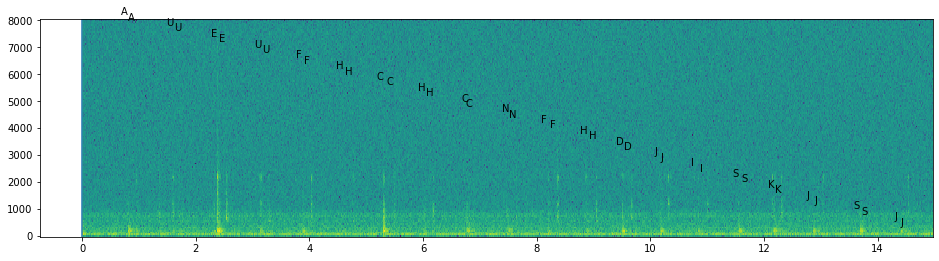

In [47]:
constructSpectrogramFigure(spectrogram, transcript)

In [27]:
"""
Condition for full: press_start > frame_start and press_end < frame_end
Condition for partial: (press_start < frame_start and press_end > frame_start) or (press_end > frame_end and 
                                    press_start < frame_end)
Condition for outside: (press_end < frame_start) or (press_start > frame_end)
"""

'\nCondition for full: press_start > frame_start and press_end < frame_end\nCondition for partial: (press_start < frame_start and press_end > frame_start) or (press_end > frame_end and \n                                    press_start < frame_end)\nCondition for outside: (press_end < frame_start) or (press_start > frame_end)\n'

In [17]:
df

,samples_0,samples_1,samples_2,samples_3,samples_4,samples_5,samples_6,samples_7,samples_8,samples_9,...,samples_9866,samples_9867,samples_9868,samples_9869,samples_9870,samples_9871,samples_9872,start_times,end_times,key_press_type
0,174,243,238,228,128,128,128,152,127,127,...,126,126,126,127,126,126,126,0,9872,outside
1,136,137,136,136,137,136,137,136,137,137,...,127,127,127,127,127,127,128,1000,10872,outside
2,139,139,139,138,140,139,139,139,139,139,...,128,129,128,128,128,129,129,2000,11872,outside
3,135,134,135,135,134,134,134,133,133,135,...,129,130,129,130,130,129,130,3000,12872,outside
4,127,129,127,127,128,127,126,128,127,126,...,129,129,129,129,129,130,130,4000,13872,outside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,128,127,127,127,128,127,128,129,128,128,...,129,128,129,129,128,128,129,224000,233872,inside
225,127,127,128,128,128,128,128,129,128,128,...,127,128,128,127,127,128,128,225000,234872,outside
226,130,129,130,129,129,130,130,129,130,129,...,128,128,129,129,129,128,128,226000,235872,outside
227,128,127,127,128,127,127,128,127,128,127,...,127,127,128,127,128,128,128,227000,236872,inside


In [29]:
window_size=9873
step_size=1000

for t in timestamps:
    transcript, _, audio_array, _ = loadAudioAndTranscript(BASE_DIR, t)
    df = generate_frame_df(audio_array, window_size, int(step_size))
    X_columns = ["samples_" + str(i) for i in range(0, window_size)]
    df["target"] = lgb_model.predict(df[X_columns])
    print(df["target"].sum())

61
24
6
15
4
1
86
99
196
189
200
184
188
189
138
138
129
125
127
103
171
195
202
176
188
195
192
152
77
72
83
78
14
85
59
162
87
79
7
11
75
7
4
5
3
5
12
3
3
5
57
81
147
78
165
78
72
141
55
47
97
85
5
84
9
79
9
60
7
90
9
99
7
114
7
101
9
102
7
92
10
11
101
4
119
8
114
11
124
17
132
38
77
18
68
4
102
10
131
5
123
16
93
7
136
16
19
104
9
6
122
7
104
3
98
11
116
8
103
14
144
7
129
13
114
16
130
13
125
136
14
105
12
94
110
24
125
19
130
12
114
8
9
114
147
14
112
36
8
176
163
7
130
10
86
8
138
155
163
91


In [48]:
df["key_press_type"]

0      outside
1      outside
2      outside
3      outside
4      outside
        ...   
226    outside
227    outside
228    outside
229    outside
230    outside
Name: key_press_type, Length: 231, dtype: object

In [18]:
def count_spacebars(transcript):
    count = 0;
    for entry in transcript["key_code"]:
        if entry == "[Space]":
           count += 1
    return count/2

In [44]:
#let's see if performing the above but using model.predict_prob() will thin out some of the false positives
window_size=9873
step_size=1000
THRESHOLD_CONSTANT = 0.99
for t in timestamps:
    transcript, _, audio_array, _ = loadAudioAndTranscript(BASE_DIR, t)
    n_spacebars = count_spacebars(transcript)
    df = generate_frame_df(audio_array, window_size, int(step_size))
    transcript, spectrogram, audio_array, _ = loadAudioAndTranscript(BASE_DIR, '1657993344379')
    transcript["rel_time_stamp_samples"] = transcript["rel_time_stamp"] * 16
    space_transcript = transcript[transcript["key_code"].str.lower().str.contains("space")]
    start_end_pairs = list(space_transcript["rel_time_stamp_samples"])
    start_end_pairs = [start_end_pairs[n:n+2] for n in range(0, len(start_end_pairs), 2)]
    df["key_press_type"] = df.apply(determine_containment, list_of_se_pairs=start_end_pairs, axis=1)
    df["key_press_type"].value_counts()
    X_columns = ["samples_" + str(i) for i in range(0, window_size)]
    probabilities = lgb_model.predict_proba(df[X_columns])
    y_pred = probabilities[:, 1]
    y_pred = np.where(y_pred > THRESHOLD_CONSTANT, 1, 0)
    y_true = df["key_press_type"].map({"inside":1, "partial":1, "outside":0})
    df["y_pred"] = y_pred
    df["target"] = y_true
    print("Detected: " + str(df["y_pred"].sum()) + "| Actual: " + str(n_spacebars) + "|" +BASE_DIR + t + "|" + str(f1_score(y_true, y_pred)))


Detected: 3| Actual: 16.0|C:\Users\kbk17\Espionage-Data\1657405825762|0.02985074626865672
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1657405846489|0.0
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1657405863666|0.0
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1657405880674|0.0
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1657405897594|0.0
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1657405914498|0.0
Detected: 16| Actual: 13.0|C:\Users\kbk17\Espionage-Data\1657405931394|0.14018691588785048
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1657405948290|0.0
Detected: 19| Actual: 15.0|C:\Users\kbk17\Espionage-Data\1657993281866|0.14746543778801846
Detected: 14| Actual: 12.5|C:\Users\kbk17\Espionage-Data\1657993301012|0.12264150943396228
Detected: 6| Actual: 14.5|C:\Users\kbk17\Espionage-Data\1657993324432|0.05940594059405941
Detected: 4| Actual: 17.0|C:\Users\kbk17\Espionage-Data\1657993344379|0.039999999999999994
Detected: 12| Actu

Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1659906941227|0.0
Detected: 66| Actual: 20.0|C:\Users\kbk17\Espionage-Data\1659906959392|0.4166666666666667
Detected: 2| Actual: 1.0|C:\Users\kbk17\Espionage-Data\1659906981262|0.01
Detected: 77| Actual: 17.0|C:\Users\kbk17\Espionage-Data\1659906997688|0.48
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1659907015770|0.0
Detected: 91| Actual: 20.5|C:\Users\kbk17\Espionage-Data\1659907032290|0.5365853658536585
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1659907049346|0.0
Detected: 2| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1659907067266|0.02
Detected: 50| Actual: 17.0|C:\Users\kbk17\Espionage-Data\1659907083620|0.3467741935483871
Detected: 1| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1659907100213|0.0
Detected: 0| Actual: 0.0|C:\Users\kbk17\Espionage-Data\1659907117680|0.0
Detected: 77| Actual: 17.0|C:\Users\kbk17\Espionage-Data\1659907134337|0.48727272727272725
Detected: 1| Actual: 0.0|C:\Users\kbk17\Espionage-

In [45]:
df

,samples_0,samples_1,samples_2,samples_3,samples_4,samples_5,samples_6,samples_7,samples_8,samples_9,...,samples_9868,samples_9869,samples_9870,samples_9871,samples_9872,start_times,end_times,key_press_type,y_pred,target
0,174,243,238,228,128,128,128,152,127,127,...,126,126,126,126,126,0,9872,outside,0,0
1,137,138,137,137,139,138,139,138,139,139,...,126,126,126,125,126,1000,10872,outside,0,0
2,141,141,141,140,142,141,141,141,141,141,...,130,130,129,130,130,2000,11872,outside,0,0
3,136,135,136,136,135,136,135,135,134,135,...,126,127,127,126,127,3000,12872,outside,0,0
4,128,129,128,128,129,128,128,129,128,128,...,125,125,124,125,125,4000,13872,outside,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,128,128,128,128,128,128,129,128,128,128,...,126,126,126,125,126,226000,235872,inside,0,1
227,130,129,129,129,129,129,130,129,130,129,...,131,130,130,130,131,227000,236872,outside,0,0
228,126,126,125,126,126,126,126,126,126,126,...,125,125,124,125,125,228000,237872,inside,0,1
229,129,129,129,129,128,128,128,128,128,127,...,130,131,132,131,132,229000,238872,inside,0,1


In [ ]:
df["target"].sum()

In [ ]:
5000/16000

In [ ]:
test = generate_list_of_frame_dfs(audio_arrays[0], FRAME_SIZE, int(STEP))
test

In [ ]:
test = audio_arrays[0].copy()
result = generate_list_of_frame_df(test, FRAME_SIZE, int(FRAME_SIZE/10))
len(result)

In [ ]:
result = generate_list_of_frame_dfs(test, FRAME_SIZE, FRAME_SIZE/10)

In [ ]:
result.shape

In [ ]:
test

In [ ]:
a = np.array(list(range(1,500000)))
a.shape

In [ ]:
x = generate_list_of_frame_dfs(a, 10000, 2000)
len(x)

In [ ]:
np.array(x).shape

In [22]:
test_n = audio_arrays[0].shape

In [ ]:
df.apply(return_next_times, window_size=window_size, step_size=step_size, axis=1)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
parameters = {'loss': ['log'],
              'penalty': ['l2', 'l1', 'elasticnet'],
              'alpha': [0.0001, 0.01, 0.1, 1, 10 ],
              'l1_ratio': [0, 0.15, 0.5, 1],
              'warm_start': [True, False]}
                
gd_pipe = Pipeline([('normalizer', Normalizer(16, True)), 
                 ('nfft', NormFFT()),
                 ('minmaxscaler', MinMaxScaler()),
                 ('gdc', GridSearchCV(SGDClassifier(), parameters))
                ])